In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# New file path and encoding
dvm_filepath = '3458 Mesures (1 ou 3 DVM) V-3_Zener_temp_meas-24h.slp'

# Read the file with the specified encoding
with open(dvm_filepath, 'r', encoding='iso-8859-1') as file:
    lines = file.readlines()

# Mapping block identifiers to meaningful names
block_names = {
    'b7': 'dvm1_voltage',
    'b8': 'dvm2_voltage',
    'b9': 'dvm3_voltage',
    'b10': 'dvm1_pp',
    'b11': 'dvm2_pp',
    'b12': 'dvm3_pp',
    'b13': 'dvm1_temp',
    'b14': 'dvm2_temp',
    'b15': 'dvm3_temp',
}

# Process the data
def process_data(lines):
    data = {}
    current_block = None
    
    for line in lines:
        line = line.strip()

        # Check for block identifier
        if re.match(r'b\d+', line):
            if current_block is not None and len(current_block['data']) > 2:
                block_name = block_names.get(current_block['name'])
                if block_name:  # Check if the block name is in the mapping
                    data[block_name] = current_block['data'][2:]  # Skip the first two elements
                
            current_block = {'name': line, 'data': [], 'skip_lines': 2}
            continue
        
        # Skip the defined number of lines after each data block identifier
        if current_block is not None and current_block['skip_lines'] > 0:
            current_block['skip_lines'] -= 1
            continue

        # Add data lines to the current block
        if current_block is not None and re.match(r'\d+\.?\d*', line):
            current_block['data'].append(float(line))
            
    if current_block is not None and len(current_block['data']) > 2:
        block_name = block_names.get(current_block['name'])
        if block_name:  # Check if the block name is in the mapping
            data[block_name] = current_block['data'][2:]  # Skip the first two elements

    return data

# Processed data blocks with meaningful names as keys
data_blocks = process_data(lines)

# Extract the data into individual variables
dvm1_voltage = np.array(data_blocks.get('dvm1_voltage', []))
dvm2_voltage = np.array(data_blocks.get('dvm2_voltage', []))
dvm3_voltage = np.array(data_blocks.get('dvm3_voltage', []))
dvm1_pp = np.array(data_blocks.get('dvm1_pp', []))
dvm2_pp = np.array(data_blocks.get('dvm2_pp', []))
dvm3_pp = np.array(data_blocks.get('dvm3_pp', []))
dvm1_temp = np.array(data_blocks.get('dvm1_temp', []))
dvm2_temp = np.array(data_blocks.get('dvm2_temp', []))
dvm3_temp = np.array(data_blocks.get('dvm3_temp', []))
# Filename for Fluke DVM
fluke_filename = 'RECORD_20231005125357.csv'

# Extracting the timestamp from the filename
fluke_timestamp_str = fluke_filename.split('_')[1].split('.')[0]
fluke_timestamp = datetime.strptime(fluke_timestamp_str, '%Y%m%d%H%M%S')

# Loading data from the CSV file into a numpy array
fluke_data = np.loadtxt(fluke_filename, delimiter=',')

# Separating ohms readings and time intervals
fluke_ohms_readings = fluke_data[:, 0]
fluke_time_intervals = fluke_data[:, 1]

# Calculating the actual timestamps for each data point
fluke_timestamps_data = [fluke_timestamp - timedelta(seconds=np.sum(fluke_time_intervals[i:])) 
                    for i in range(len(fluke_time_intervals))]


# Correcting the Fluke timestamp by adding 2 hours
fluke_timestamps = np.array([time + timedelta(hours=2) for time in fluke_timestamps_data])

# Constants for Callendar-Van Dusen equation
A = 3.9083e-3
B = -5.775e-7
R0 = 100.0  # Resistance at 0°C for PT100

# Calculate temperature from ohms readings using the Callendar-Van Dusen equation
fluke_temperatures = (-A + np.sqrt(A**2 - 4*B*(1 - fluke_ohms_readings / R0))) / (2*B)


# Print out some values to verify
print("\nFluke DVM Data:")
print("Ohms readings:", fluke_ohms_readings[:5])
print("Time intervals:", fluke_time_intervals[:5])
print("Temperatures:", fluke_temperatures[:5])
print("Timestamps:", fluke_timestamps[:5])

# Print lengths to verify
print("Length of DVM1 Voltage:", len(dvm1_voltage))
print("Length of DVM2 Voltage:", len(dvm2_voltage))
print("Length of DVM3 Voltage:", len(dvm3_voltage))
print("Length of DVM1 PP:", len(dvm1_pp))
print("Length of DVM2 PP:", len(dvm2_pp))
print("Length of DVM3 PP:", len(dvm3_pp))
print("Length of DVM1 Temperature:", len(dvm1_temp))
print("Length of DVM2 Temperature:", len(dvm2_temp))
print("Length of DVM3 Temperature:", len(dvm3_temp))



Fluke DVM Data:
Ohms readings: [109.93523 109.94217 109.94991 109.95693 109.96381]
Time intervals: [0.2     1.20008 1.20008 1.20008 1.20008]
Temperatures: [25.51705907 25.53495112 25.55490577 25.57300428 25.59074194]
Timestamps: [datetime.datetime(2023, 10, 4, 14, 28, 6, 846900)
 datetime.datetime(2023, 10, 4, 14, 28, 7, 46900)
 datetime.datetime(2023, 10, 4, 14, 28, 8, 246980)
 datetime.datetime(2023, 10, 4, 14, 28, 9, 447060)
 datetime.datetime(2023, 10, 4, 14, 28, 10, 647140)]
Length of DVM1 Voltage: 8656
Length of DVM2 Voltage: 8656
Length of DVM3 Voltage: 8656
Length of DVM1 PP: 8656
Length of DVM2 PP: 8656
Length of DVM3 PP: 8656
Length of DVM1 Temperature: 8656
Length of DVM2 Temperature: 8656
Length of DVM3 Temperature: 8656


In [2]:
import matplotlib.dates as mdates

# Known start time for DVM data
dvm_start_time = datetime(2023, 10, 4, 14, 48, 8)

# Creating a numpy array of timestamps for the DVM data
dvm_timestamps = np.array([dvm_start_time + timedelta(seconds=i*10) for i in range(len(dvm1_voltage))])


# Determining the overlapping time range
start_time = max(dvm_timestamps[0], fluke_timestamps[0])  # The later start time
end_time = min(dvm_timestamps[-1], fluke_timestamps[-1])  # The earlier end time

# Filtering the DVM data to the overlapping range
dvm_overlap_mask = (dvm_timestamps >= start_time) & (dvm_timestamps <= end_time)
dvm_overlap_timestamps = dvm_timestamps[dvm_overlap_mask]
dvm1_voltage_overlap = dvm1_voltage[dvm_overlap_mask]
dvm2_voltage_overlap = dvm2_voltage[dvm_overlap_mask]
dvm3_voltage_overlap = dvm3_voltage[dvm_overlap_mask]

# Filtering the Fluke DVM data to the overlapping range
fluke_overlap_mask = (fluke_timestamps >= start_time) & (fluke_timestamps <= end_time)
fluke_overlap_timestamps = fluke_timestamps[fluke_overlap_mask]
fluke_temperatures_overlap = fluke_temperatures[fluke_overlap_mask]

# print the timestamps to verify
print("\nDVM timestamps:", dvm_overlap_timestamps[:5])
print("Fluke timestamps:", fluke_overlap_timestamps[:5])



DVM timestamps: [datetime.datetime(2023, 10, 4, 14, 48, 8)
 datetime.datetime(2023, 10, 4, 14, 48, 18)
 datetime.datetime(2023, 10, 4, 14, 48, 28)
 datetime.datetime(2023, 10, 4, 14, 48, 38)
 datetime.datetime(2023, 10, 4, 14, 48, 48)]
Fluke timestamps: [datetime.datetime(2023, 10, 4, 14, 48, 8, 323000)
 datetime.datetime(2023, 10, 4, 14, 48, 9, 523080)
 datetime.datetime(2023, 10, 4, 14, 48, 10, 723150)
 datetime.datetime(2023, 10, 4, 14, 48, 11, 923230)
 datetime.datetime(2023, 10, 4, 14, 48, 13, 123310)]


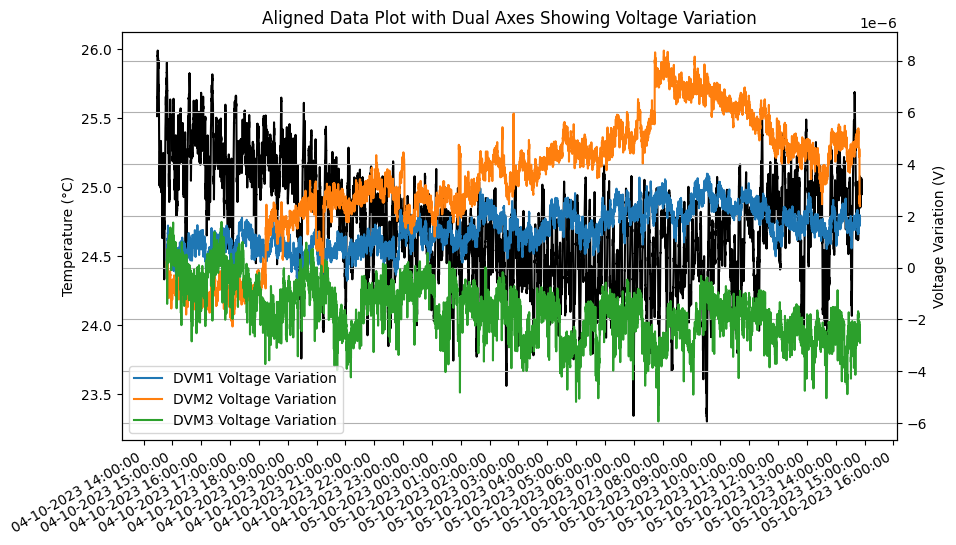

In [3]:

import matplotlib.dates as mdates

# Plotting the data with two different scales
plt.figure(figsize=(10, 6))

# Create the second axis first to plot temperature data
ax2 = plt.gca()

# Plot Fluke temperature data, without filtering for overlapping timestamps
ax2.plot(fluke_timestamps, fluke_temperatures, color='black')

# Labeling for this y-axis
ax2.set_ylabel('Temperature (°C)')

# Create the first axis to plot DVM data
ax1 = ax2.twinx()

# Calculating the variation of DVM voltage data from the initial value
dvm1_voltage_variation = dvm1_voltage - dvm1_voltage[0]
dvm2_voltage_variation = dvm2_voltage - dvm2_voltage[0]
dvm3_voltage_variation = dvm3_voltage - dvm3_voltage[0]

# Plot all DVM voltage variations, without filtering for overlapping timestamps
ax1.plot(dvm_timestamps, dvm1_voltage_variation, label='DVM1 Voltage Variation')
ax1.plot(dvm_timestamps, dvm2_voltage_variation, label='DVM2 Voltage Variation')
ax1.plot(dvm_timestamps, dvm3_voltage_variation, label='DVM3 Voltage Variation')

# Labeling and formatting for this y-axis
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Voltage Variation (V)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M:%S'))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.grid(True)

# Auto format the x-axis labels to fit them better
plt.gcf().autofmt_xdate()

# Show only DVM data in the legend
ax1.legend(loc='lower left')

# Add a title
plt.title('Aligned Data Plot with Dual Axes Showing Voltage Variation')

# Show plot
plt.show()

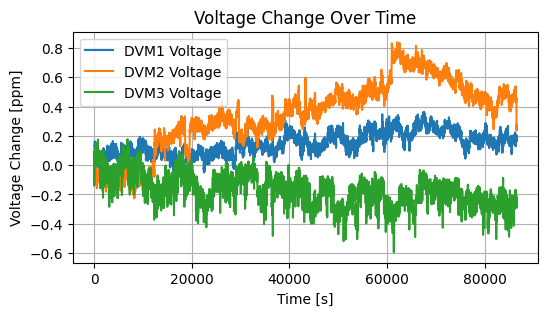

In [8]:
# Now plot the data
# Plot voltages
plt.figure(figsize=(6, 3))
time_in_seconds = np.arange(0, len(dvm1_voltage) * 10, 10)

plt.plot(time_in_seconds, 1e5*(dvm1_voltage-dvm1_voltage[0]), label='DVM1 Voltage')
plt.plot(time_in_seconds, 1e5*(dvm2_voltage-dvm2_voltage[0]), label='DVM2 Voltage')
plt.plot(time_in_seconds, 1e5*(dvm3_voltage-dvm3_voltage[0]), label='DVM3 Voltage')
# Adding labels and title
plt.xlabel('Time [s]')
plt.ylabel('Voltage Change [ppm]')
plt.title('Voltage Change Over Time')

plt.legend()
plt.grid(True)

# Format the x-axis labels to show time in hh:mm format
ax = plt.gca()

# save png
plt.savefig('91_dvm_voltage_over_time.png', dpi=300, bbox_inches='tight')

plt.show()


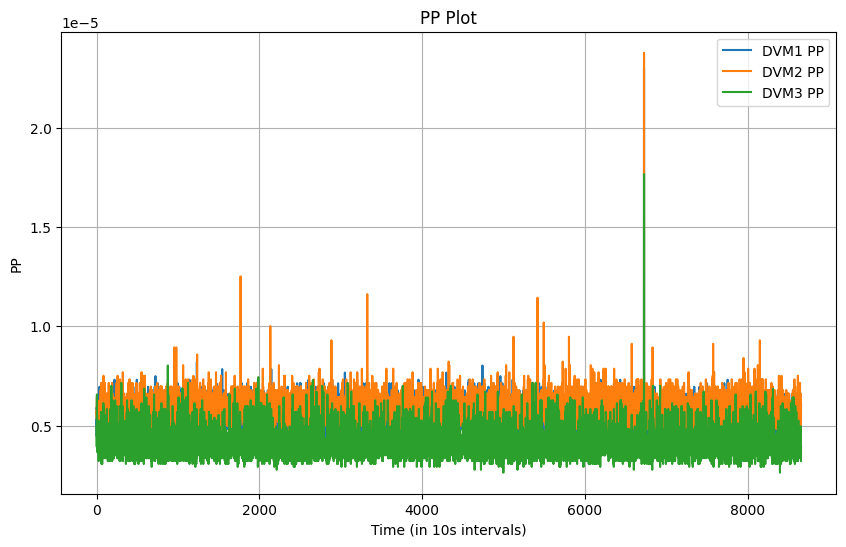

In [21]:

# Plot PP
plt.figure(figsize=(10, 6))
plt.plot(dvm1_pp, label='DVM1 PP')
plt.plot(dvm2_pp, label='DVM2 PP')
plt.plot(dvm3_pp, label='DVM3 PP')
plt.title('PP Plot')
plt.xlabel('Time (in 10s intervals)')
plt.ylabel('PP')
plt.legend()
plt.grid(True)
plt.show()


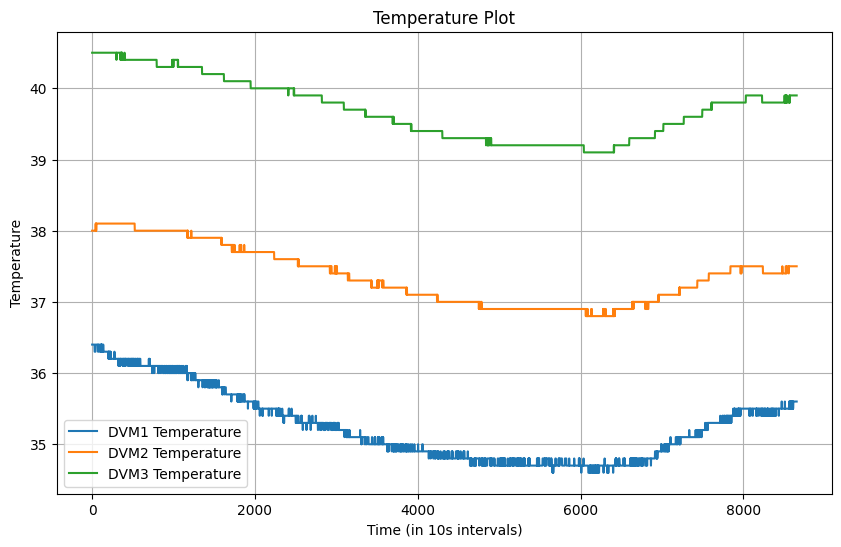

In [22]:

# Plot temperatures
plt.figure(figsize=(10, 6))
plt.plot(dvm1_temp, label='DVM1 Temperature')
plt.plot(dvm2_temp, label='DVM2 Temperature')
plt.plot(dvm3_temp, label='DVM3 Temperature')
plt.title('Temperature Plot')
plt.xlabel('Time (in 10s intervals)')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()